In [ ]:
!git clone https://github.com/twpkevin06222/Liver-Segmentation-Project-.git medical_imaging

Cloning into 'medical_imaging'...
remote: Enumerating objects: 581, done.
remote: Total 581 (delta 0), reused 0 (delta 0), pack-reused 581
Receiving objects: 100% (581/581), 299.41 MiB | 27.47 MiB/s, done.
Resolving deltas: 100% (181/181), done.


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd
import keras.backend as k
from keras.utils import to_categorical
from keras import metrics
from keras.models import Model, load_model, Sequential
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Maximum, Flatten
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose, Conv3D, Conv3DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D, MaxPooling3D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from sklearn.utils import class_weight

from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
import os

In [ ]:
import h5py
from keras.layers import concatenate,UpSampling2D

In [ ]:
!pip install nibabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import keras
print('Tensorflow version:', tf.__version__)
print('Keras version:', keras.__version__)

Tensorflow version: 2.12.0
Keras version: 2.12.0


In [ ]:
import glob
import nibabel as nib
def three_to_two(path, label='FALSE'):
    ff = sorted(glob.glob(path))
    images =[]
    for f in range(len(ff)):
        a = nib.load(ff[f])
        a = a.get_data()
        for i in range(a.shape[2]):
            images.append(a[:,:,i])
    images = np.asarray(images)
    #images = images.reshape(-1, 128,128, 1) # dimension to feed into the network
    return images

def min_max_norm(images):
    m = np.max(images)
    mi = np.min(images)
    images = (images - mi)/ (m - mi)
    return images

def label_outliers(img_labels):
    img_labels[img_labels>1]=1
    img_labels[img_labels<0]=0
    return img_labels

#Image for training
images = three_to_two(path='medical_imaging/tmp/tmp_img/img_new/*')
x_data = min_max_norm(images)

#labels
img_labels = three_to_two(path='medical_imaging/tmp/tmp_img/img_new_label/*')
y_data = label_outliers(img_labels)

#Test Image
img_test = three_to_two(path='medical_imaging/tmp/tmp_img/test_img/*')
x_test = min_max_norm(img_test)

#Test Labels
label_test = three_to_two(path='medical_imaging/tmp/tmp_img/test_img_label/*')
y_test = label_outliers(label_test)

<ipython-input-6-d20bf1b9e6f3>:8: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  a = a.get_data()


In [ ]:
x_data.shape

(3036, 128, 128)

In [ ]:
y_data.shape

(3036, 128, 128)

In [ ]:
x_test.shape

(735, 128, 128)

In [ ]:
y_test.shape

(735, 128, 128)

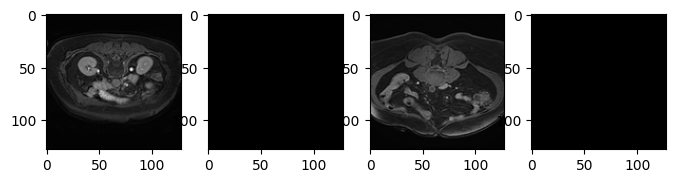

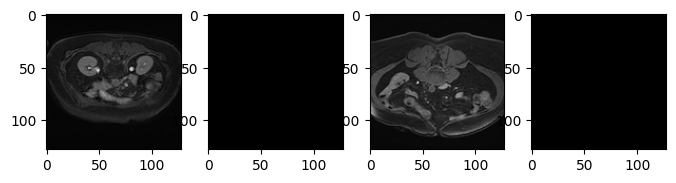

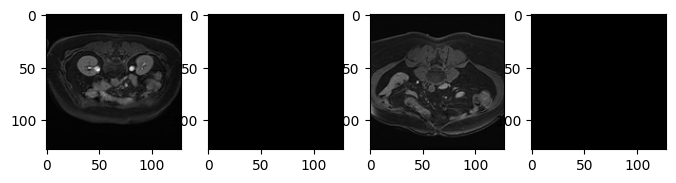

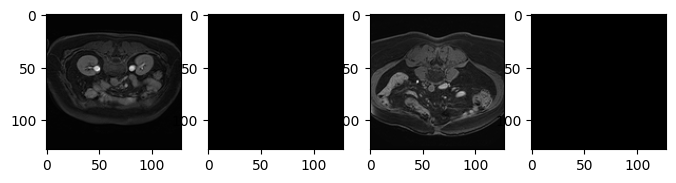

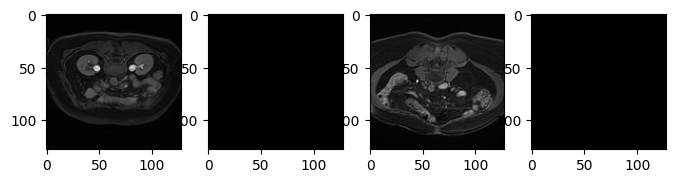

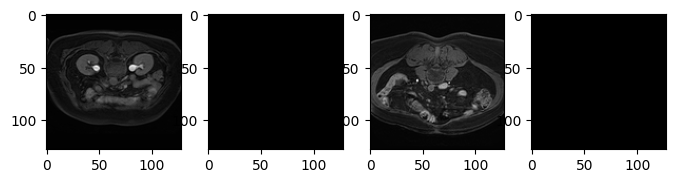

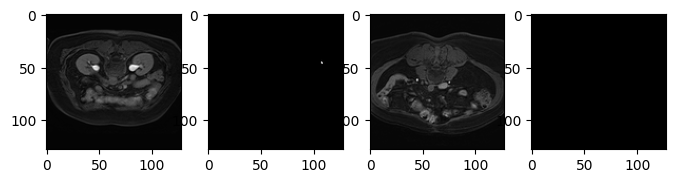

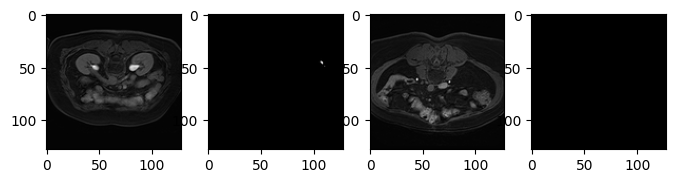

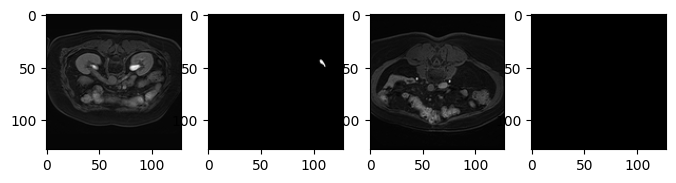

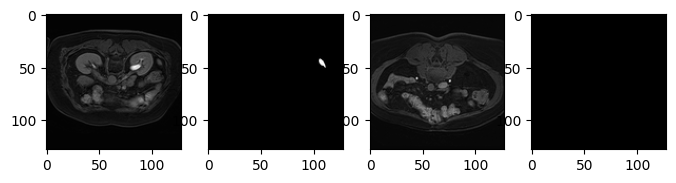

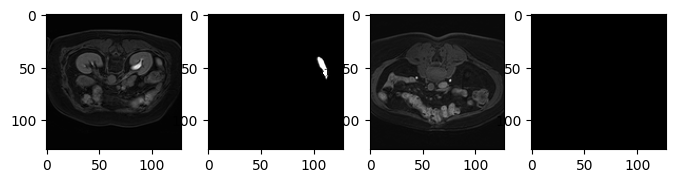

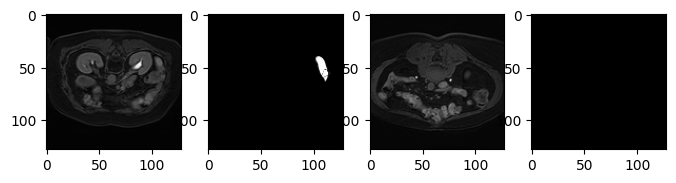

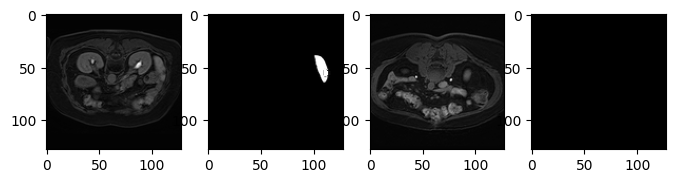

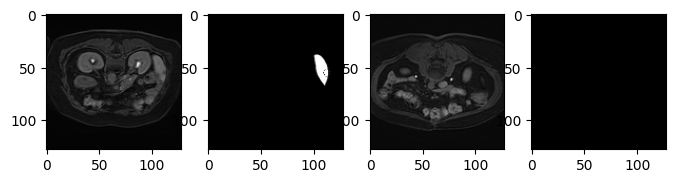

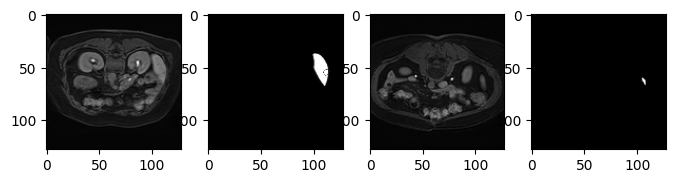

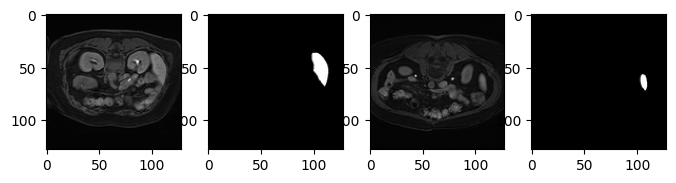

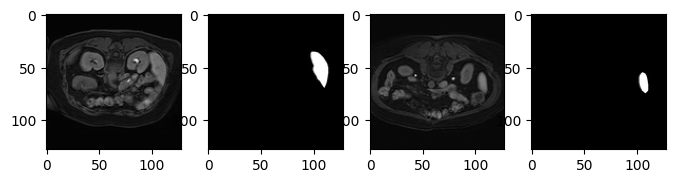

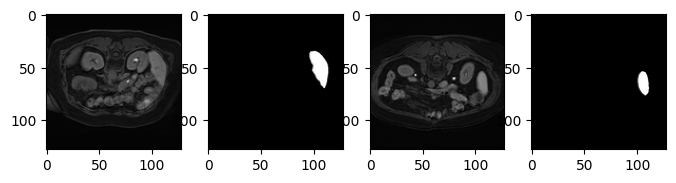

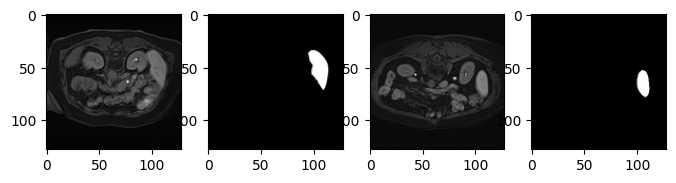

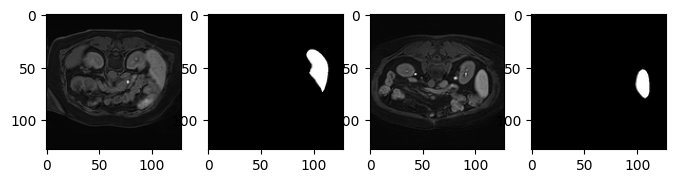

In [ ]:
for i in range(20):
    fig, ax = plt.subplots(1,4, figsize = (8,4))
    ax[0].imshow(x_data[i], cmap='gray')
    ax[1].imshow(y_data[i], cmap='gray')
    ax[2].imshow(x_test[i], cmap='gray')
    ax[3].imshow(y_test[i], cmap='gray')

plt.show()

In [ ]:
x_data = x_data[:,:,:,np.newaxis] # same as reshape (-1,128,128,1)
y_data = y_data[:,:,:,np.newaxis]
x_test = x_test[:,:,:,np.newaxis]
y_test = y_test[:,:,:,np.newaxis]

print('Dimension for training data:', x_data.shape)
print('Dimension for training data labels:', y_data.shape)
print('Dimension for test data:', x_test.shape)
print('Dimension for test data labels:', y_test.shape)

Dimension for training data: (3036, 128, 128, 1)
Dimension for training data labels: (3036, 128, 128, 1)
Dimension for test data: (735, 128, 128, 1)
Dimension for test data labels: (735, 128, 128, 1)


In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.2, random_state =42)
x_test, y_test = shuffle(x_test, y_test, random_state= 42)

In [ ]:
x_train.shape

(2428, 128, 128, 1)

In [ ]:
y_train.shape

(2428, 128, 128, 1)

In [ ]:
x_test.shape

(735, 128, 128, 1)

In [ ]:
y_test.shape

(735, 128, 128, 1)

In [ ]:
from keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
input_layer = Input(shape=x_train.shape[1:])

In [ ]:
input_layer.shape

TensorShape([None, 128, 128, 1])

In [ ]:
pip install merge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for merge: filename=merge-1.0.0-py3-none-any.whl size=1466 sha256=8884af910dfffa0ab345ba44cc863ecf01a2cf42ed888bde3bbdbe824ea28424
  Stored in directory: /root/.cache/pip/wheels/05/dd/d8/def14d2e509c76947b5c561b30a68602ebdbb6d4c985618743
Successfully built merge


In [ ]:
def lenet():
    Model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(6, (5, 5),(1,1), activation='relu', input_shape=input_layer),
        tf.keras.layers.MaxPooling2D((2, 2),(2,2)),
        tf.keras.layers.Conv2D(16, (5, 5),(1,1), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2),(2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120, activation='relu'),
        tf.keras.layers.Dense(84, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    return Model

def conv_block(x_in, filters, batch_norm, kernel_size=(3,3)):
    x = Conv2D(filters, kernel_size, padding='same')(x_in)
    if batch_norm=='TRUE':
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    if batch_norm=='TRUE':
        x = BatchNormalization()(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def conv_2d(x_in, filters, batch_norm, kernel_size=(3,3),acti ='relu'):
    x = Conv2D(filters, kernel_size, padding='same')(x_in)
    if batch_norm=='TRUE':
        x=BatchNormalization()(x)
    x= Activation(acti)(x)
    return x

def pool(x_in, pool_size=(2, 2), type='Max'):
    if type=='Max':
        p = MaxPooling2D(pool_size)(x_in)
    return p

def up(x_in, filters, merge, batch_norm, size=(2,2)):
    u = UpSampling2D(size)(x_in)
    conv = conv_block(u, filters, batch_norm)
    merge=concatenate([merge, conv],axis=-1)
    return merge

def CNN(input_layer):
    conv1 = conv_block(input_layer, filters=16, batch_norm='TRUE')
    pool1 = pool(conv1)

    conv2 = conv_block(pool1, filters=32, batch_norm='TRUE')
    pool2 = pool(conv2)

    conv3 = conv_block(pool2, filters=32, batch_norm='TRUE')
    pool3 = pool(conv3)

    conv4 = conv_block(pool3, filters=64, batch_norm='TRUE')
    pool4 = pool(conv4)

    conv5 = conv_2d(pool4, filters=128, batch_norm='TRUE')

    up1 = up(conv5,filters=128, merge=conv4, batch_norm='TRUE')
    conv6 = conv_2d(up1, filters=128, batch_norm='TRUE')

    up2 = up(conv6, filters=128, merge=conv3, batch_norm='TRUE')
    conv7 = conv_2d(up2, filters=128, batch_norm='TRUE')

    up3 = up(conv7, filters=64, merge=conv2, batch_norm='TRUE')
    conv8 = conv_2d(up3, filters=64, batch_norm='TRUE')

    up4 = up(conv8, filters=32, merge=conv1, batch_norm='TRUE')
    conv9 = conv_2d(up4, filters=32, batch_norm='TRUE')

    conv10 = conv_2d(conv9, filters=1, batch_norm='FALSE', acti='sigmoid')

    output_layer = conv10
    model = Model(input_layer, output_layer)

    return model

In [ ]:
model = CNN(input_layer)

In [ ]:
model.compile(optimizer=Adam(1e-4), loss= dice_coef_loss, metrics=[dice_coef])

In [ ]:
from tensorflow.keras import layers

In [ ]:
hist = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
76/76 [==============================] - 39s 259ms/step - loss: 0.6990 - dice_coef: 0.3011 - val_loss: 0.8884 - val_dice_coef: 0.1116
Epoch 2/50
76/76 [==============================] - 13s 166ms/step - loss: 0.4256 - dice_coef: 0.5746 - val_loss: 0.9269 - val_dice_coef: 0.0731
Epoch 3/50
76/76 [==============================] - 13s 167ms/step - loss: 0.2171 - dice_coef: 0.7829 - val_loss: 0.9034 - val_dice_coef: 0.0966
Epoch 4/50
76/76 [==============================] - 13s 175ms/step - loss: 0.1328 - dice_coef: 0.8673 - val_loss: 0.6936 - val_dice_coef: 0.3064
Epoch 5/50
76/76 [==============================] - 13s 177ms/step - loss: 0.0944 - dice_coef: 0.9057 - val_loss: 0.5022 - val_dice_coef: 0.4978
Epoch 6/50
76/76 [==============================] - 13s 173ms/step - loss: 0.0765 - dice_coef: 0.9235 - val_loss: 0.2599 - val_dice_coef: 0.7401
Epoch 7/50
76/76 [==============================] - 13s 173ms/step - loss: 0.0643 - dice_coef: 0.9357 - val_loss: 0.1114 - val_dic

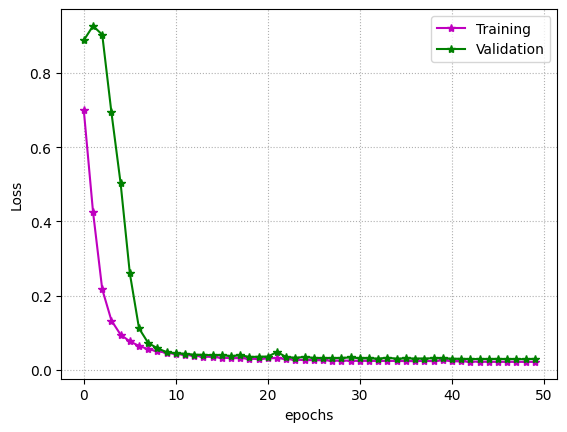

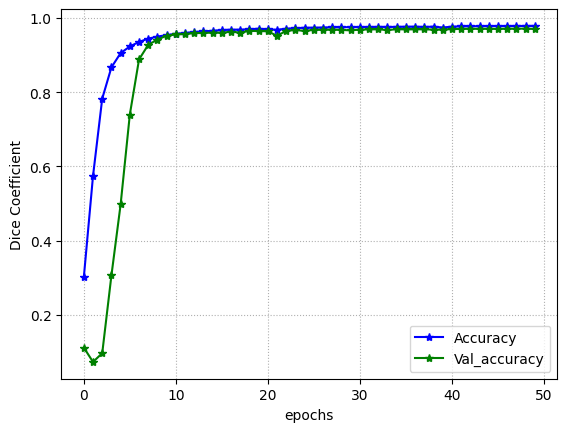

In [ ]:
plt.plot(hist.history['loss'], color='m', marker = '*',label='Training')
plt.plot(hist.history['val_loss'], color='g', marker = '*',label='Validation')
plt.legend(loc='upper right')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.grid(linestyle='dotted')
plt.show()

plt.plot(hist.history['dice_coef'], color='b',marker = '*', label='Accuracy')
plt.plot(hist.history['val_dice_coef'], color='g',marker = '*', label='Val_accuracy')
plt.xlabel("epochs")
plt.ylabel("Dice Coefficient")
plt.legend(loc='lower right')
plt.grid(linestyle='dotted')
plt.show()

In [ ]:
test_eval = model.evaluate(x_test, y_test, verbose=1, batch_size = 32)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

23/23 [==============================] - 4s 135ms/step - loss: 0.0533 - dice_coef: 0.9467
Test loss: 0.05327794700860977
Test accuracy: 0.9466985464096069


23/23 [==============================] - 1s 45ms/step


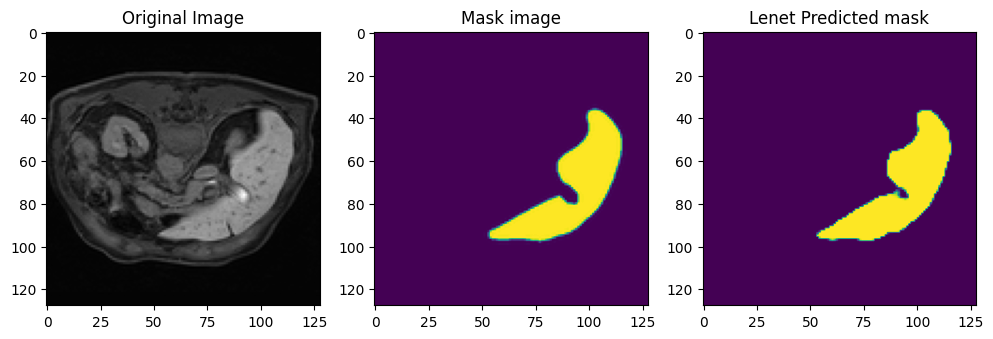

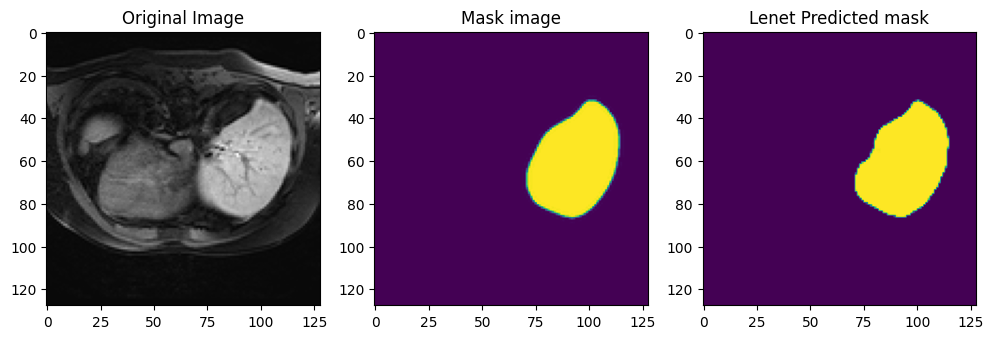

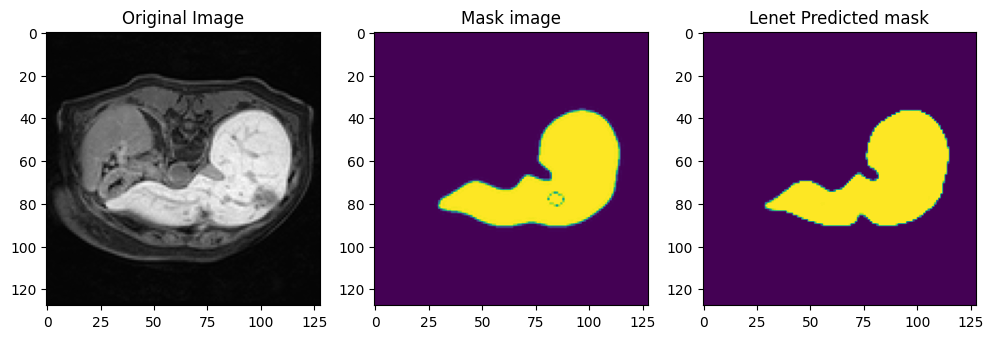

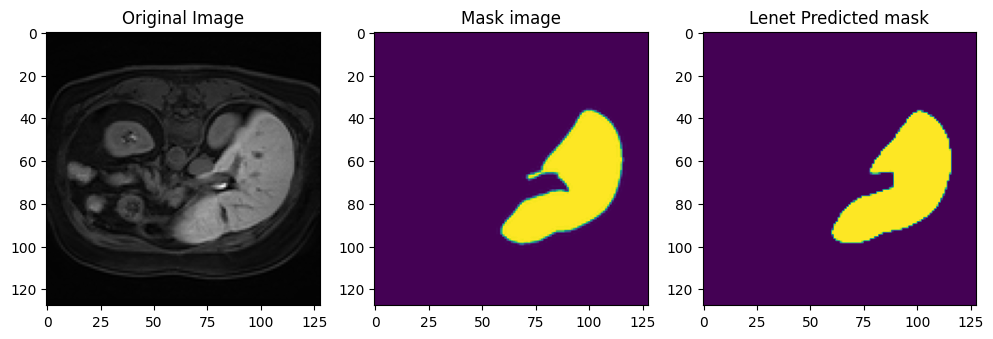

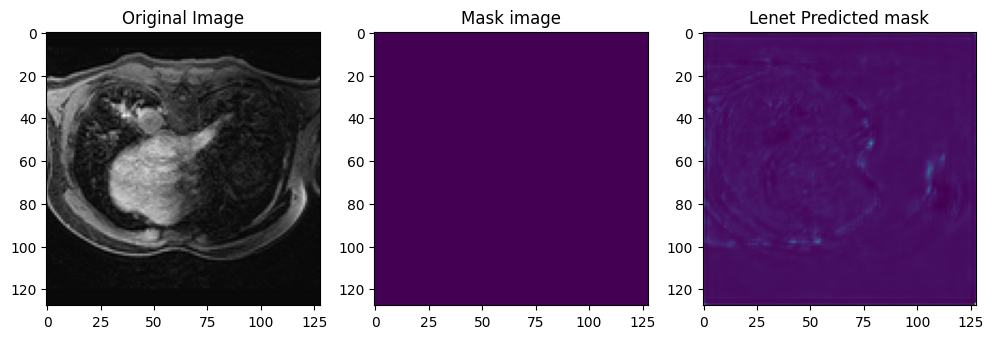

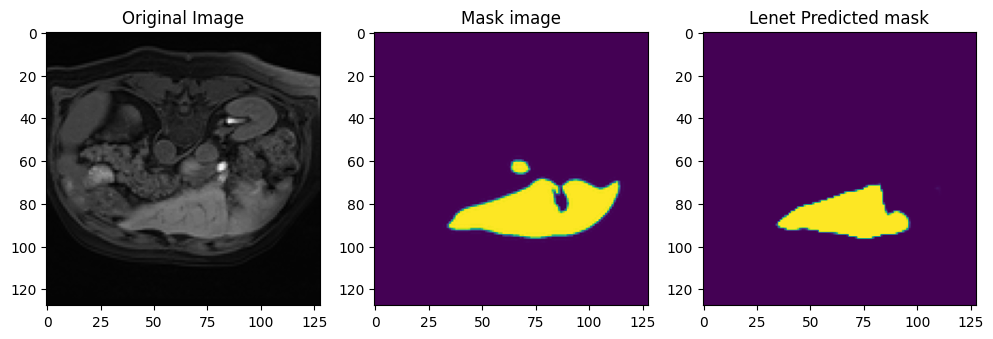

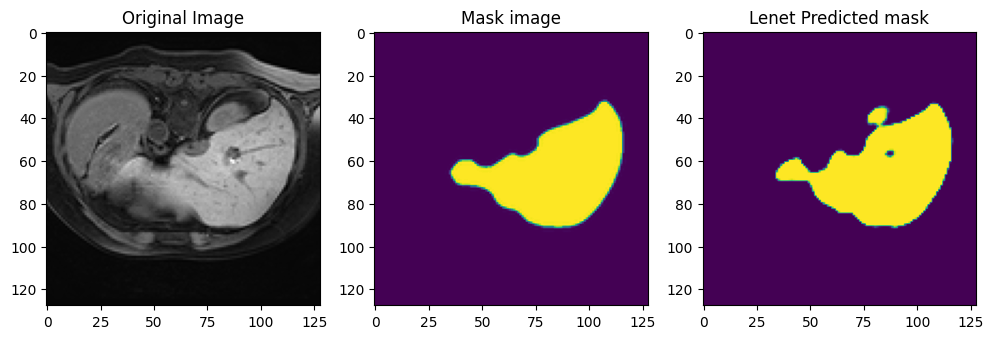

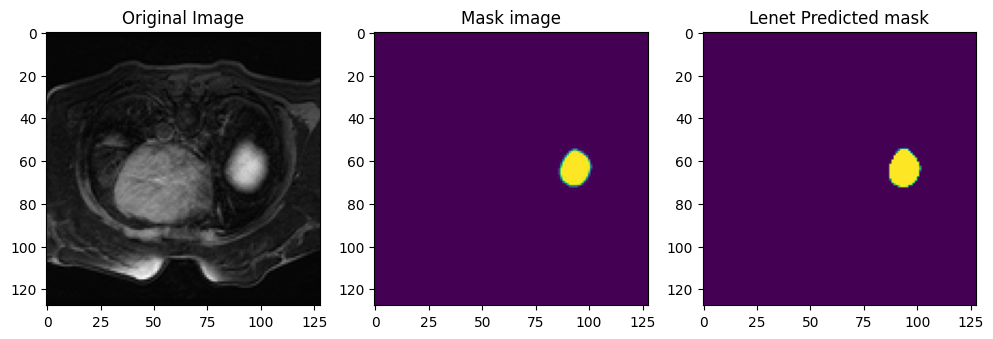

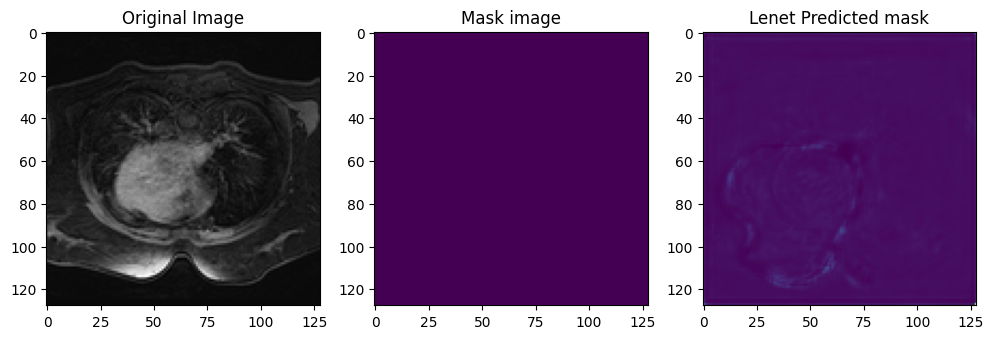

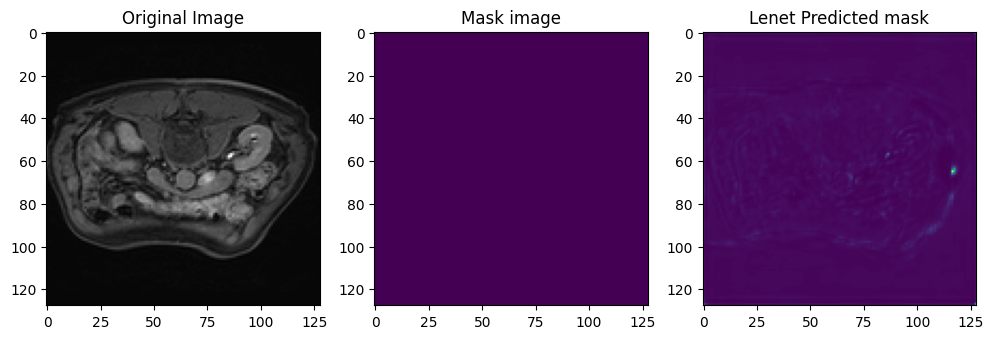

In [ ]:
y_pred = model.predict(x_test)
for i in range(0,20,2):
    fig, ax = plt.subplots(1,3,figsize=(12,6))
    ax[0].imshow(x_test[i,:,:,0], cmap='gray')
    ax[0].set_title('Original Image')
    ax[1].imshow(y_test[i,:,:,0], cmap='viridis')
    ax[1].set_title('Mask image')
    ax[2].imshow(y_pred[i,:,:,0], cmap='viridis')
    ax[2].set_title('Lenet Predicted mask')
plt.show()

In [ ]:
intersection = np.logical_and(y_test, y_pred)
precision_for_predicted_tumor = intersection.sum() / y_test.sum()
recall_for_predicted_tumor = intersection.sum() / y_pred.sum()

In [ ]:
print(precision_for_predicted_tumor)

1.2732935961051168


In [ ]:
print(recall_for_predicted_tumor)

1.347831759453677
